In [1]:
!pip install pandas yfinance backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.1/410.1 kB 7.3 MB/s eta 0:00:00


Final Portfolio Value: 1227985.94


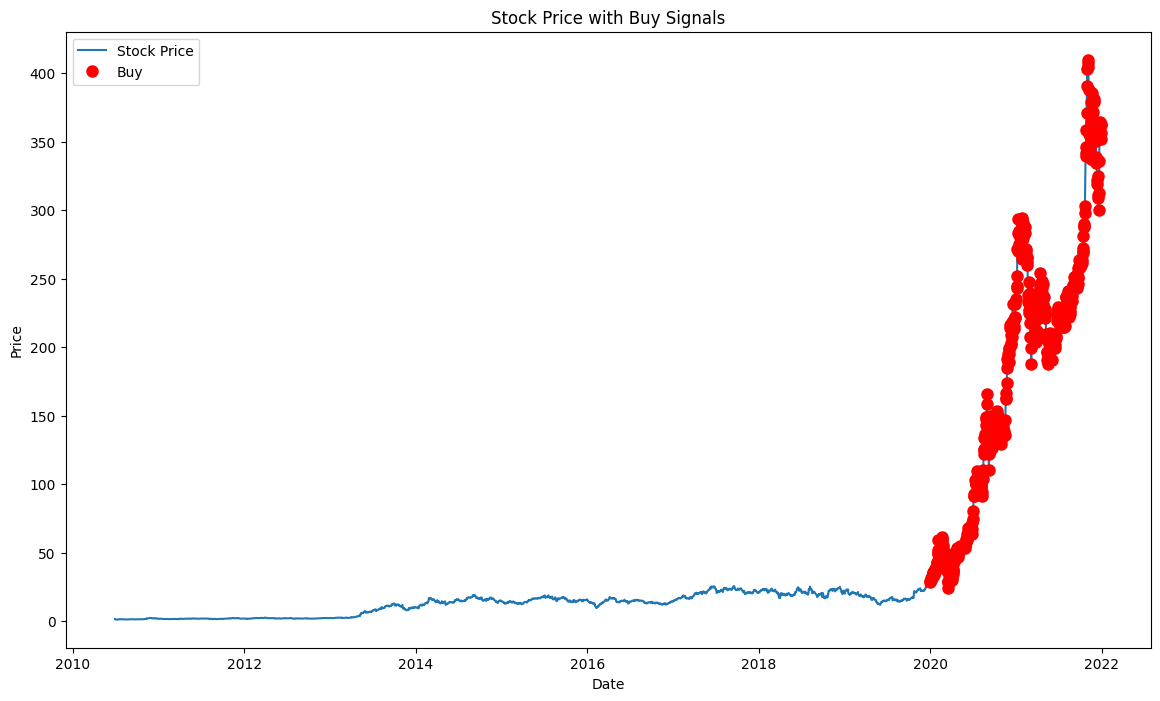

In [10]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

API_KEY = "YOUR_API_KEY_HERE"

def get_financial_data(stock, statement_type):
    url = f"https://cloud.iexapis.com/stable/stock/{stock}/financials?token={API_KEY}&period=annual&last=5"
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data["financials"])

def get_price_data(stock, start_date, end_date):
    url = f"https://cloud.iexapis.com/stable/stock/{stock}/chart/max?token={API_KEY}&chartCloseOnly=true"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["date"])
    return df[(df["date"] >= start_date) & (df["date"] <= end_date)]

def calculate_profitability_factors(financial_data, financial_data_prev):
    roa = financial_data["netIncome"] / financial_data["totalAssets"]
    if financial_data_prev is not None:
        roa_prev = financial_data_prev["netIncome"] / financial_data_prev["totalAssets"]
        roa_increase = (roa - roa_prev) > 0
    else:
        roa_increase = False

    return {
        "net_income_positive": financial_data["netIncome"] > 0,
        "operating_cash_flow_positive": financial_data["cashFlow"] > 0,
        "roa_increase": roa_increase,
    }

def backtest_profitability_factors(price_data, financial_data):
    starting_cash = 100000
    shares = 0

    for index, row in price_data.iterrows():
        current_year = row["date"].year
        financials_for_year = financial_data[financial_data["fiscalYear"] == int(current_year)]
        financials_prev_year = financial_data[financial_data["fiscalYear"] == int(current_year) - 1]

        if not financials_for_year.empty:
            factors = calculate_profitability_factors(financials_for_year.iloc[0], financials_prev_year.iloc[0] if not financials_prev_year.empty else None)

            if (
                factors["net_income_positive"]
                and factors["operating_cash_flow_positive"]
                and factors["roa_increase"]
            ):
                shares_to_buy = starting_cash // row["close"]
                starting_cash -= shares_to_buy * row["close"]
                shares += shares_to_buy

    final_cash = starting_cash + shares * price_data.iloc[-1]["close"]
    return final_cash

def backtest_profitability_factors(price_data, financial_data):
    starting_cash = 100000
    shares = 0
    buy_points = []

    for index, row in price_data.iterrows():
        current_year = row["date"].year
        financials_for_year = financial_data[financial_data["fiscalYear"] == int(current_year)]
        financials_prev_year = financial_data[financial_data["fiscalYear"] == int(current_year) - 1]

        if not financials_for_year.empty:
            factors = calculate_profitability_factors(financials_for_year.iloc[0], financials_prev_year.iloc[0] if not financials_prev_year.empty else None)

            if (
                factors["net_income_positive"]
                and factors["operating_cash_flow_positive"]
                and factors["roa_increase"]
            ):
                shares_to_buy = starting_cash // row["close"]
                starting_cash -= shares_to_buy * row["close"]
                shares += shares_to_buy
                buy_points.append({"date": row["date"], "price": row["close"]})

    final_cash = starting_cash + shares * price_data.iloc[-1]["close"]
    return final_cash, buy_points

def plot_stock_with_buy_signals(price_data, buy_points):
    plt.figure(figsize=(14, 8))
    plt.plot(price_data["date"], price_data["close"], label="Stock Price")
    for point in buy_points:
        plt.plot(point["date"], point["price"], "ro", markersize=8, label="Buy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Stock Price with Buy Signals")
    plt.legend(["Stock Price", "Buy"])
    plt.show()

def main():
    stock = "TSLA"
    start_date = "2010-01-01"
    end_date = "2022-01-01"

    financial_data = get_financial_data(stock, "financials")
    price_data = get_price_data(stock, start_date, end_date)

    final_portfolio_value, buy_points = backtest_profitability_factors(price_data, financial_data)
    print(f"Final Portfolio Value: {final_portfolio_value:.2f}")

    plot_stock_with_buy_signals(price_data, buy_points)

if __name__ == "__main__":
    main()